<a href="https://colab.research.google.com/github/MahdiBouzaher/Facial_emotion_recognition_with_ML/blob/main/facial_emotion_recognition_rf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [332]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# **Loading JAFFE Dataset**

In [333]:
# Function to load images from a folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename), cv2.IMREAD_GRAYSCALE)

        parts = filename.split('.')
        if len(parts) < 2:
            continue
        code = parts[1][:2]
        if code == "DI":
            continue
        if img is not None:
            images.append(img)
    return images

# Loading The images
JAFFE_PATH = "/content/drive/MyDrive/AI_assignement_1/JAFFE_DS"
jaffe_images= load_images_from_folder(JAFFE_PATH)
jaffe_images = np.array(jaffe_images)

In [334]:
# Function to create y_ndarray using from the file name
def get_y_from_filenames(folder):
    emotions = {'AN':0, 'FE':1, 'HA':2, 'SA':3, 'SU':4, 'NE':5}
    y = []
    for filename in os.listdir(folder):
        parts = filename.split('.')
        if len(parts) < 2:
            continue
        code = parts[1][:2]
        if code in emotions:
            y.append(emotions[code])
    return np.array(y)

# Passing the path of the folder to the function to get y ndarray
y_jaffe = get_y_from_filenames(JAFFE_PATH)

print(f"CK images shape: {jaffe_images.shape}")
print(f"JAFFE labels: {np.unique(y_jaffe)}")
print(f"CK label counts: {np.bincount(y_jaffe)}")

CK images shape: (184, 256, 256)
JAFFE labels: [0 1 2 3 4 5]
CK label counts: [30 32 31 31 30 30]


# **Loading CK+ Dataset**

In [335]:
# Loading CK+ dataset
CK_PATH = "/content/drive/MyDrive/AI_assignement_1/Cohn-Kanade.csv"
df = pd.read_csv(CK_PATH)
df = df.drop(columns=['Usage'])

# Remove disgust (1) and contempt (7)
df = df[df['emotion'] != '1']
df = df[df['emotion'] != '7']

# Map emotions to 0-5 range
emotion_mapping = {0: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}
df['emotion_mapped'] = df['emotion'].astype(int).map(emotion_mapping)

# Remove any NaN values from mapping
df = df.dropna(subset=['emotion_mapped'])

# Extract images
ck_images = np.array([np.fromstring(str(x), sep=' ') for x in df['pixels']])
ck_images = ck_images.reshape(-1, 48, 48)

# Use MAPPED labels
y_ck = df['emotion_mapped'].values.astype(int)

print(f"CK images shape: {ck_images.shape}")
print(f"CK labels: {np.unique(y_ck)}")
print(f"CK label counts: {np.bincount(y_ck)}")

CK images shape: (843, 48, 48)
CK labels: [0 1 2 3 4 5]
CK label counts: [ 45  25  69  28  83 593]


# **Function to reshape all images from both datasets to 64x64**
JAFFE   256 X 256 => 64 X 64

CK+     48 X 48 => 64 X 64

In [336]:
# Function to resize all images to 64x64
def resize_images(images):
    resized_images = []
    for image in images:
        resized_image = cv2.resize(image, (64, 64), interpolation=cv2.INTER_CUBIC)
        resized_images.append(resized_image)
    return np.array(resized_images)

# Call the function to resize the images
ck_images = resize_images(ck_images)
jaffe_images = resize_images(jaffe_images)

print(ck_images.shape)
print(jaffe_images.shape)

(843, 64, 64)
(184, 64, 64)


# **Face Detection**

In [337]:
# Raw GitHub URL for the face cascade
HAAR_CASCADE_URL = 'https://raw.githubusercontent.com/opencv/opencv/refs/heads/master/data/haarcascades/haarcascade_frontalface_default.xml'

# Name for the local file
HAAR_CASCADE_FILE = 'haarcascade_frontalface_default.xml'

# Download the cascade file
import urllib.request
urllib.request.urlretrieve(HAAR_CASCADE_URL, HAAR_CASCADE_FILE)

# Loading the Cascade
face_cascade = cv2.CascadeClassifier(HAAR_CASCADE_FILE)

# function to detect faces
def detect_face(images):
    # In your detect_face function
    face_images = []
    for image in images:
        gray = image.copy().astype(np.uint8)
        face_rect = face_cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=5)

        if len(face_rect) > 0:
            # Assume only one face, take the first one
            (x, y, w, h) = face_rect[0]
            # CROP the image to the face
            face_cropped = gray[y:y+h, x:x+w]
            # Resize the cropped face to a standard size so HOG works consistently
            face_resized = cv2.resize(face_cropped, (64, 64), interpolation=cv2.INTER_AREA)
            face_images.append(face_resized)
        else:
            # If no face is detected, you could append the original resized image
            # or decide to skip it. For now, let's append the original.
            face_images.append(gray) # gray is already 64x64 at this point

    return np.array(face_images)

# Detecting face on jaffe dataset
jaffe_X = detect_face(jaffe_images)
jaffe_X = np.array(jaffe_X)

# Detecting face on ck dataset
X_ck = detect_face(ck_images)
X_ck = np.array(X_ck)

# **HOC  + PCA + SCALING Functions**

In [338]:
def get_hog_features(images):
    hog_X = []
    for image in images:
       hog_X_features, hog_image = hog(image, orientations=9,
                                          pixels_per_cell=(8, 8),
                                          cells_per_block=(2, 2),
                                          visualize=True)
       hog_X.append(hog_X_features)
    return hog_X

In [339]:
def scale_data(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled


In [340]:
def pca(X_train, X_test):
    pca = PCA(n_components=60, whiten=True, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    print(f"Explained variance: {pca.explained_variance_ratio_.sum():.2%}")

    return X_train_pca, X_test_pca

# **Random Forest Model**

In [351]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    random_state=42
)

# **Training and testing**

In [352]:
print("\nTesting on JAFFE Dataset")

# Extract HOG features
hog_X_jaffe = get_hog_features(jaffe_X)
hog_X_jaffe = np.array(hog_X_jaffe)

# Flatten HOG features
hog_X_jaffe = hog_X_jaffe.reshape(hog_X_jaffe.shape[0], -1)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(hog_X_jaffe,
                                                    y_jaffe, test_size=0.3,
                                                    random_state=42)

# Scale (fit on train, transform both)
X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

print("\nWITHOUT PCA")
# Train WITHOUT PCA
rf_model.fit(X_train_scaled, y_train)
score_no_pca = rf_model.score(X_test_scaled, y_test)
print(f"Accuracy WITHOUT PCA: {score_no_pca:.2%}")

print("\nWITH PCA")
# Step 5: Add PCA
X_train_pca, X_test_pca = pca(X_train_scaled, X_test_scaled)

# Train WITH PCA
rf_model.fit(X_train_pca, y_train)
score_with_pca = rf_model.score(X_test_pca, y_test)
print(f"Accuracy WITH PCA: {score_with_pca:.2%}")


Testing on JAFFE Dataset

WITHOUT PCA
Accuracy WITHOUT PCA: 60.71%

WITH PCA
Explained variance: 81.87%
Accuracy WITH PCA: 62.50%


In [353]:
print("\nTesting on CK+ Dataset")

# Extract HOG features
hog_X_ck = np.array(get_hog_features(X_ck))
print(f"CK+ HOG shape: {hog_X_ck.shape}")

# Split dataset
X_train_ck, X_test_ck, y_train_ck, y_test_ck = train_test_split(hog_X_ck,
                                                                y_ck,
                                                                test_size=0.3,
                                                                random_state=42)

# Scale data
X_train_ck_scaled, X_test_ck_scaled = scale_data(X_train_ck, X_test_ck)

# Train WITHOUT PCA
print("\nWITHOUT PCA")
rf_model.fit(X_train_ck_scaled, y_train_ck)
score_no_pca = rf_model.score(X_test_ck_scaled, y_test_ck)
print(f"Accuracy WITHOUT PCA: {score_no_pca:.2%}")

# Train WITH PCA
print("\nWITH PCA")
X_train_ck_pca, X_test_ck_pca = pca(X_train_ck_scaled, X_test_ck_scaled)
rf_model.fit(X_train_ck_pca, y_train_ck)
score_with_pca = rf_model.score(X_test_ck_pca, y_test_ck)
print(f"Accuracy WITH PCA: {score_with_pca:.2%}")


Testing on CK+ Dataset
CK+ HOG shape: (843, 1764)

WITHOUT PCA
Accuracy WITHOUT PCA: 83.79%

WITH PCA
Explained variance: 57.53%
Accuracy WITH PCA: 78.66%


In [356]:
print("COMBINING BOTH DATASETS")

# Extract HOG features from both
hog_X_jaffe = get_hog_features(jaffe_X)
hog_X_jaffe = np.array(hog_X_jaffe)

hog_X_ck = get_hog_features(X_ck)
hog_X_ck = np.array(hog_X_ck)

# Combine datasets
X_combined = np.vstack([hog_X_jaffe, hog_X_ck])
y_combined = np.concatenate([y_jaffe, y_ck])

print(f"Combined dataset shape: {X_combined.shape}")
print(f"Combined labels shape: {y_combined.shape}")
print(f"Label distribution: {np.bincount(y_combined.astype(int))}")

# Split combined data
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(X_combined,
                                                                                        y_combined,
                                                                                        test_size=0.3,
                                                                                        random_state=42,
                                                                                        stratify=y_combined)

# Scale
X_train_combined_scaled, X_test_combined_scaled = scale_data(X_train_combined, X_test_combined)

# Train on combined data
rf_model.fit(X_train_combined_scaled, y_train_combined)
score_combined = rf_model.score(X_test_combined_scaled, y_test_combined)
print(f"\nCOMBINED Dataset Accuracy: {score_combined:.2%}")

COMBINING BOTH DATASETS
Combined dataset shape: (1027, 1764)
Combined labels shape: (1027,)
Label distribution: [ 75  57 100  59 113 623]

COMBINED Dataset Accuracy: 79.94%


Classification Report for Combined Dataset
              precision    recall  f1-score   support

           0       1.00      0.20      0.33        15
           1       1.00      0.27      0.43        11
           2       0.94      0.75      0.83        20
           3       0.83      0.42      0.56        12
           4       0.94      0.65      0.77        23
           5       0.77      0.99      0.86       125

    accuracy                           0.80       206
   macro avg       0.91      0.55      0.63       206
weighted avg       0.83      0.80      0.77       206



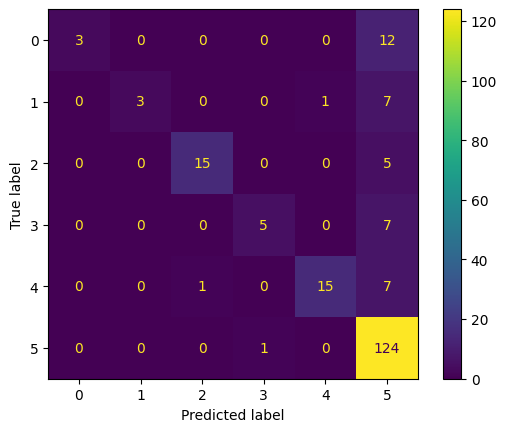

In [355]:
y_pred_combined = rf_model.predict(X_test_combined_scaled)

print("Classification Report for Combined Dataset")
print(classification_report(y_test_combined, y_pred_combined))

# Also, visualize the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test_combined, y_pred_combined)
plt.show()